In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [65]:
data=pd.read_csv('TemperaturenHof.csv',delimiter=';')

In [66]:
dataU=data.drop('eor',axis=1)

In [67]:
Q1 = dataU.quantile(0.25)
Q3 = dataU.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
dfNO = dataU[~((dataU < lower_bound) | (dataU > upper_bound)).any(axis=1)]

In [68]:
dfNO

,STATIONS_ID,MESS_DATUM,QN_4,TT_TER,RF_TER
0,2261,1947010107,5,-6.6,94.0
1,2261,1947010114,5,-5.3,89.0
2,2261,1947010121,5,-5.2,93.0
3,2261,1947010207,5,-4.8,91.0
4,2261,1947010214,5,-2.3,92.0
...,...,...,...,...,...
84613,2261,2023123100,3,3.1,89.0
84614,2261,2023123106,3,3.3,90.0
84615,2261,2023123112,3,4.9,81.0
84616,2261,2023123118,3,4.4,87.0


In [69]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
values_scaled = scaler.fit_transform(dfNO['TT_TER'].values.reshape(-1, 1))

In [70]:
def preprocess_windowing(dataset, window_size):
    """
    Pre-processes the dataset into overlapping windows.
    
    Args:
        dataset (array-like): The input dataset (1D or column of a DataFrame).
        window_size (int): The size of each window (w).

    Returns:
        X (list): List of inputs (windows of size w-1).
        y (list): List of outputs (w-th data point).
    """
    X, y = [], []
    
    # Iterate to create windows
    for i in range(len(dataset) - window_size + 1):
        window = dataset[i:i + window_size]
        X.append(window[:-1])  # First w-1 points as input
        y.append(window[-1])   # w-th point as output
    
    return np.array(X), np.array(y)

# Define window size
window_size = 10

# Apply windowing
X, y = preprocess_windowing(dfNO['TT_TER'].values, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Define RNN model
model = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(window_size-1, 1)),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/20
2063/2063 [==============================] - 10s 4ms/step - loss: 11.1602 - mae: 2.3389 - val_loss: 8.8013 - val_mae: 2.2389
Epoch 2/20
2063/2063 [==============================] - 9s 4ms/step - loss: 6.9083 - mae: 1.9480 - val_loss: 8.5032 - val_mae: 2.1504
Epoch 3/20
2063/2063 [==============================] - 9s 4ms/step - loss: 6.6936 - mae: 1.9138 - val_loss: 8.5873 - val_mae: 2.1661
Epoch 4/20
2063/2063 [==============================] - 9s 4ms/step - loss: 6.5998 - mae: 1.8975 - val_loss: 8.6351 - val_mae: 2.1713
Epoch 5/20
2063/2063 [==============================] - 9s 4ms/step - loss: 6.6136 - mae: 1.9000 - val_loss: 8.4298 - val_mae: 2.1504
Epoch 6/20
2063/2063 [==============================] - 9s 4ms/step - loss: 6.5107 - mae: 1.8853 - val_loss: 8.4139 - val_mae: 2.1362
Epoch 7/20
2063/2063 [==============================] - 9s 4ms/step - loss: 6.4665 - mae: 1.8783 - val_loss: 8.4495 - val_mae: 2.1556
Epoch 8/20
2063/2063 [==============================] - 9s 4

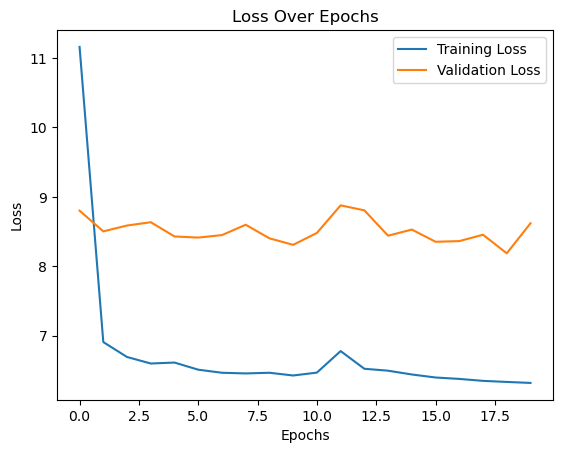

2578/2578 [==============================] - 3s 1ms/step


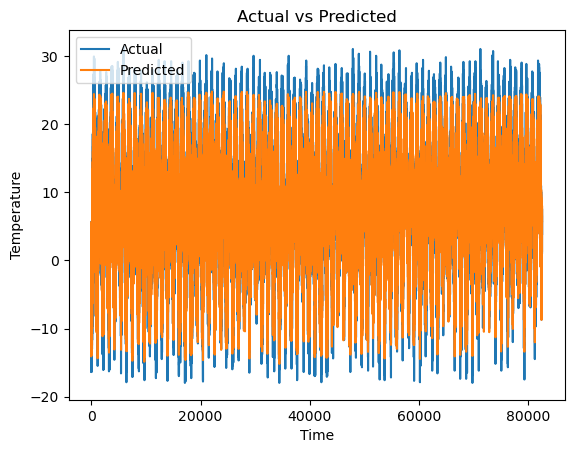

In [73]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate predictions and compare with actual values
y_pred = model.predict(X)
y_test_re=y.reshape(-1,1)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test_re)


plt.plot(range(len(y)), y, label='Actual')
plt.plot(range(len(y_pred)), y_pred, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()


In [51]:
from tensorflow.keras.layers import LSTM

model = Sequential([
    LSTM(50, activation='tanh', input_shape=(window_size-1, 1)),
    Dense(1, activation='linear')
])


In [52]:
model = Sequential([
    LSTM(50, activation='tanh', return_sequences=True, input_shape=(window_size-1, 1)),
    LSTM(30, activation='tanh'),
    Dense(1, activation='linear')
])


In [53]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


In [55]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predictions
y_pred = model.predict(X_test)

Epoch 1/20
2063/2063 [==============================] - 10s 4ms/step - loss: 12.6205 - mae: 2.5818 - val_loss: 9.0974 - val_mae: 2.2737
Epoch 2/20
2063/2063 [==============================] - 8s 4ms/step - loss: 7.4544 - mae: 2.0295 - val_loss: 8.4063 - val_mae: 2.1739
Epoch 3/20
2063/2063 [==============================] - 8s 4ms/step - loss: 6.7750 - mae: 1.9226 - val_loss: 8.5405 - val_mae: 2.2133
Epoch 4/20
2063/2063 [==============================] - 8s 4ms/step - loss: 6.6309 - mae: 1.9019 - val_loss: 8.2978 - val_mae: 2.1370
Epoch 5/20
2063/2063 [==============================] - 8s 4ms/step - loss: 6.5011 - mae: 1.8831 - val_loss: 8.4291 - val_mae: 2.1516
Epoch 6/20
2063/2063 [==============================] - 8s 4ms/step - loss: 6.4154 - mae: 1.8715 - val_loss: 8.2576 - val_mae: 2.1159
Epoch 7/20
2063/2063 [==============================] - 8s 4ms/step - loss: 6.3483 - mae: 1.8603 - val_loss: 7.9936 - val_mae: 2.0832
Epoch 8/20
2063/2063 [==============================] - 8s 4

NameError: name 'scaler' is not defined

In [61]:

y_test_re=y_test.reshape(-1,1)

y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test_re)

# Evaluate model performance
mse = np.mean((y_pred_inv - y_test_inv) ** 2)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 19691.7405


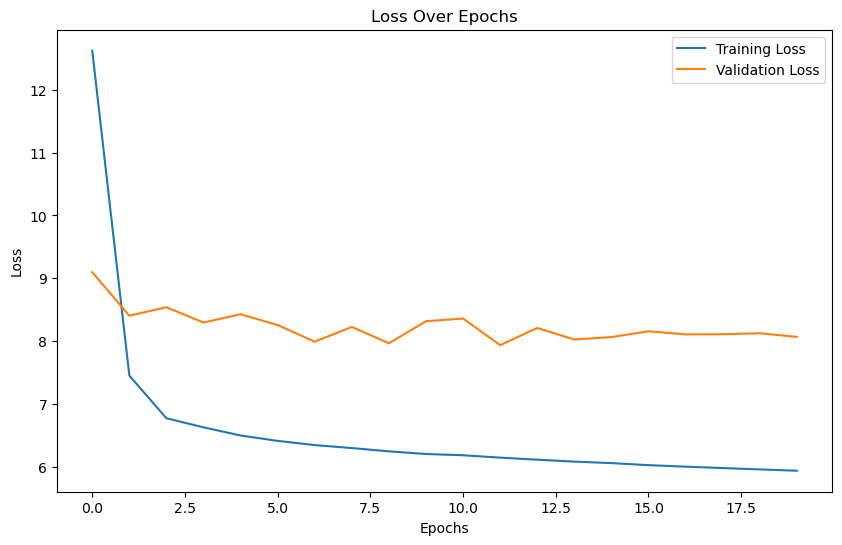

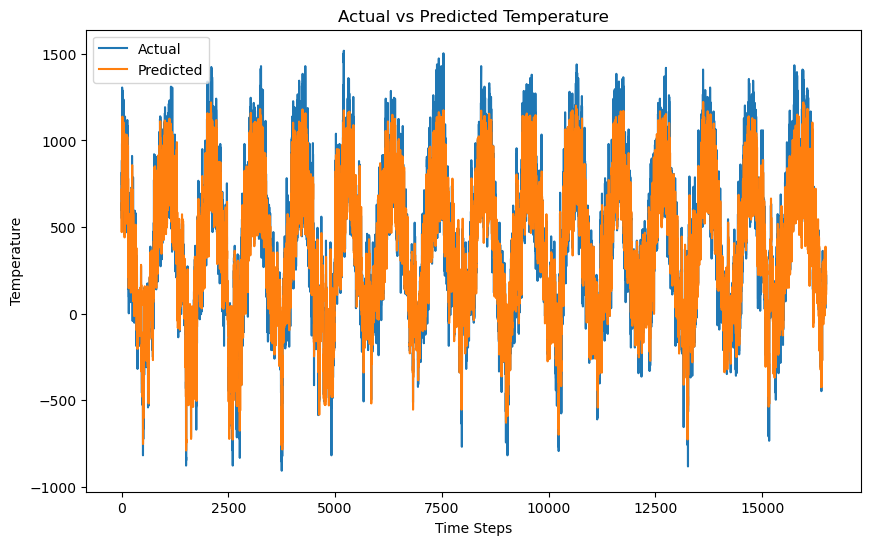

In [62]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Actual vs Predicted Temperature')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()